# Prévisions météo en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [2]:
# récupération des librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Modèles de classification par apprentissage supervisé

In [3]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [11]:
# distribution de la variable cible dans l'ensemble d'entraînement
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

0    87624
1    25005
Name: RainTomorrow, dtype: int64
0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64


In [12]:
# distribution de la variable cible dans l'ensemble de test
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

0    21962
1     6196
Name: RainTomorrow, dtype: int64
0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64


In [13]:
# undersampling des données
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print("Cardinalité des classes de la variable cible sous-échantillonnée:", dict(pd.Series(y_train_ru).value_counts()))

Cardinalité des classes de la variable cible sous-échantillonnée: {0: 25005, 1: 25005}


In [14]:
# paramètre à initialiser pour calculer les performances des algorithmes avec ré-échantillonage
param_ru = 'under_sample'

if param_ru == 'under_sample':
    X_train = X_train_ru
    y_train = y_train_ru

In [15]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## K-plus proches voisins

In [16]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(20,41,1),
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn)

In [17]:
start_time = time.time()

# entraînement
gcv_knn.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'metric': 'minkowski', 'n_neighbors': 39} 

Accuracy Score: 0.7887989203778677 

Train Data Score: 0.7923415316936613
Test Data Score: 0.7887989203778677

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17387  4575
1             1372  4824
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     21962
           1       0.51      0.78      0.62      6196

    accuracy                           0.79     28158
   macro avg       0.72      0.79      0.74     28158
weighted avg       0.84      0.79      0.80     28158

Running Time: 0:25:03.103682


- la méthode des K-plus proches voisins ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.79.
- la spécificité (taux de vrais négatifs) vaut 0.78.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.85).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.62).

In [18]:
cv_scores = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.77804439 0.77846431 0.77870426]
Average cross-validation score: 0.7784043191361727


- Le score de la méthode KNN est en moyenne de : 0.78.

In [20]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_knn_' + param_ru]).to_csv('scores/scores_clf_knn_' + param_ru + '.csv')

In [21]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev pour des valeurs de k allant de 1 à 40
# temps de calcul : ~ 12 min.
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

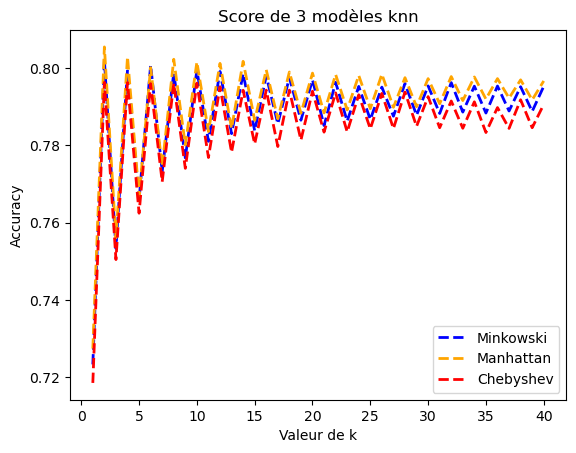

In [23]:
# affichage des listes crées en fonction de k
plt.title("Score de 3 modèles knn")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.xlabel("Valeur de k")
plt.ylabel("Accuracy")
plt.legend();

In [19]:
# Les distances de Minkowski et de Manhattan donnent de meilleures performances que les distances de Chebyshev. Les résultats restent similaires.
# Plus la valeur de k est grande, meilleurs sont les résultats.
# Le meilleur score absolu, est obtenu avec la distance de Minkowski pour un k=39.

## Interprétation de modèle avec Skater

In [29]:
# Nous utilisons Interpretation et InMemoryModel de la librairie Skater.

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_train, feature_names=X_train.columns)

model = InMemoryModel(gcv_knn.predict_proba, examples = X_train)

[13/13] features ████████████████████ Time elapsed: 327 seconds

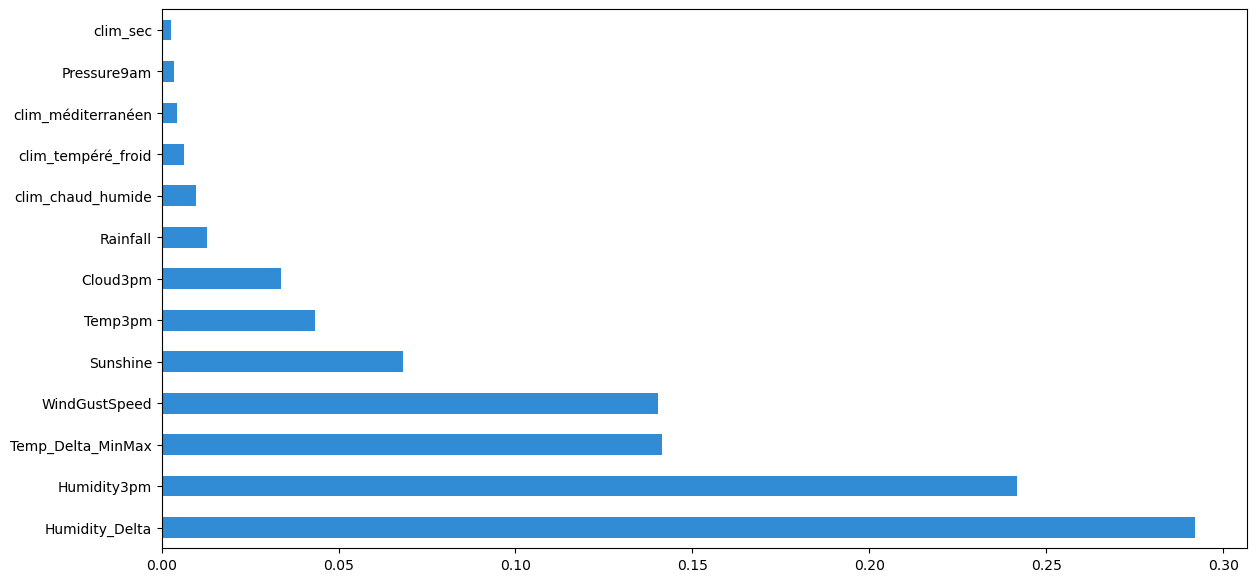

In [30]:
# Affichons le graphique de feature importance obtenue avec la librairie Skater.

plt.rcParams['figure.figsize'] = (14,7)

plots = interpreter.feature_importance.plot_feature_importance(
    model, ascending=True)

[94/94] grid cells ████████████████████ Time elapsed: 24 seconds

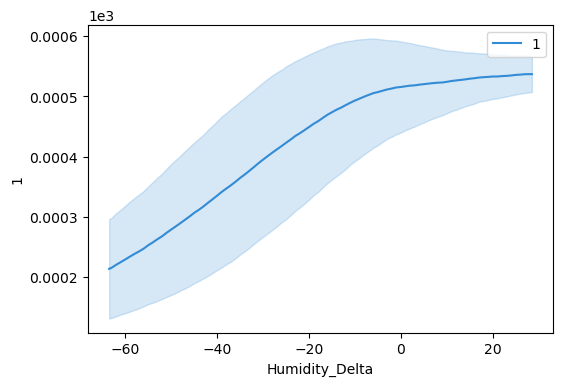

In [31]:
# Affichons le PD plot des variables ayant le plus d'importance

interpreter.partial_dependence.plot_partial_dependence(['Humidity_Delta'], model, grid_resolution=100,
                                                       with_variance=True, figsize=(6, 4));

In [ ]:
# Plus le delta d'humidité est grand plus il y a de chance qu'il pleuve le lendemain

[73/73] grid cells ████████████████████ Time elapsed: 19 seconds

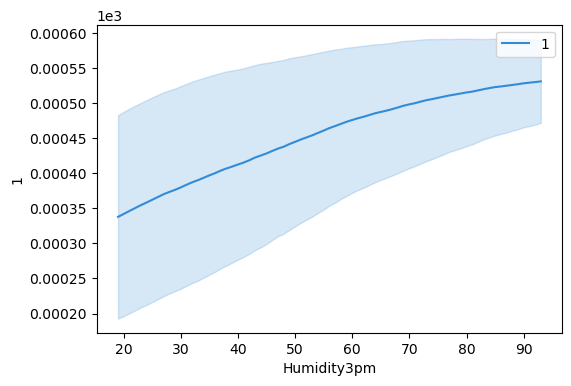

In [32]:
interpreter.partial_dependence.plot_partial_dependence(['Humidity3pm'], model, grid_resolution=100,
                                                       with_variance=True, figsize=(6, 4));

In [ ]:
# Plus le taux d'humidité est grand plus il y a de chance qu'il pleuve le lendemain

[100/100] grid cells ████████████████████ Time elapsed: 26 seconds

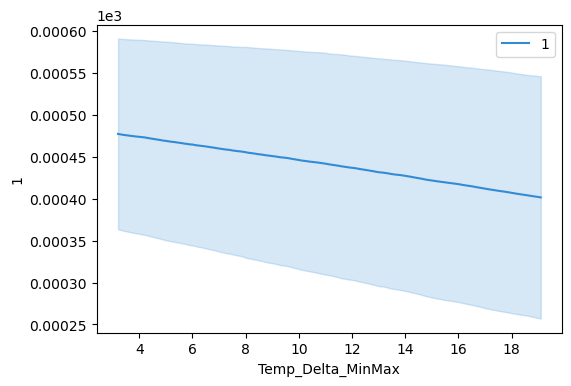

In [33]:
interpreter.partial_dependence.plot_partial_dependence(['Temp_Delta_MinMax'], model, grid_resolution=100,
                                                       with_variance=True, figsize=(6, 4));

In [ ]:
# Plus le delta de température est petit plus il y a de chance qu'il pleuve le lendemain